### Predicting the type of crime going to happen in a location using

##### Importing the necessary libraries

In [1]:
import pandas as pd

##### Importing the dataset

In [2]:
crimes_df = pd.read_csv('Crimes-2019_to_2021.csv')
crimes_df.head(5)

ID Case Number         Date                   Block  IUCR  \
0  11552667    JC100123  1/1/19 0:00        004XX N STATE ST   890   
1  11552674    JC100085  1/1/19 0:00      092XX S NORMAL AVE   910   
2  11552709    JC100020  1/1/19 0:00   044XX S WASHTENAW AVE   486   
3  11552758    JC100058  1/1/19 0:00  063XX S MARSHFIELD AVE  1310   
4  11553168    JC100745  1/1/19 0:00    008XX N MICHIGAN AVE   890   

          Primary Type              Description Location Description  Arrest  \
0                THEFT            FROM BUILDING           RESTAURANT   False   
1  MOTOR VEHICLE THEFT               AUTOMOBILE               STREET   False   
2              BATTERY  DOMESTIC BATTERY SIMPLE            APARTMENT   False   
3      CRIMINAL DAMAGE              TO PROPERTY            APARTMENT   False   
4                THEFT            FROM BUILDING           RESTAURANT   False   

   Domestic  ...  Ward  Community Area  FBI Code  X Coordinate Y Coordinate  \
0     False  ...  42.0             8.0         6     1176302.0    1903096.0   
1     False  ...  21.0            73.0         7     1174586.0    1843723.0   
2      True  ...  15.0            58.0       08B     1159112.0    1875020.0   
3     False  ...  16.0            67.0        14     1166414.0    1862607.0   
4     False  ...   2.0             8.0         6     1177330.0    1906499.0   

   Year     Updated On   Latitude  Longitude                       Location  
0  2019  1/10/19 15:16  41.889453 -87.627995  (41.889453169, -87.627994833)  
1  2019  1/10/19 15:16  41.726566 -87.636066  (41.726566477, -87.636065622)  
2  2019  1/10/19 15:16  41.812780 -87.691894  (41.812780011, -87.691893746)  
3  2019  1/10/19 15:16  41.778565 -87.665464   (41.77856457, -87.665463557)  
4  2019  1/10/19 15:16  41.898768 -87.624116  (41.898767916, -87.624116333)  

[5 rows x 22 columns]

In [3]:
# printing datatypes 
crimes_df.dtypes

ID                        int64
Case Number              object
Date                     object
Block                    object
IUCR                     object
Primary Type             object
Description              object
Location Description     object
Arrest                     bool
Domestic                   bool
Beat                      int64
District                  int64
Ward                    float64
Community Area          float64
FBI Code                 object
X Coordinate            float64
Y Coordinate            float64
Year                      int64
Updated On               object
Latitude                float64
Longitude               float64
Location                 object
dtype: object

In [4]:
# shape of dataset before cleaning
crimes_df.shape

(680425, 22)

##### Converting the column names to a standard form and handling inconsistencies

In [5]:
crimes_df.columns =crimes_df.columns.str.strip()
crimes_df.columns = crimes_df.columns.str.replace(' ', '_')
crimes_df.columns = crimes_df.columns.str.lower()

##### Checking for outliers 

<AxesSubplot: >

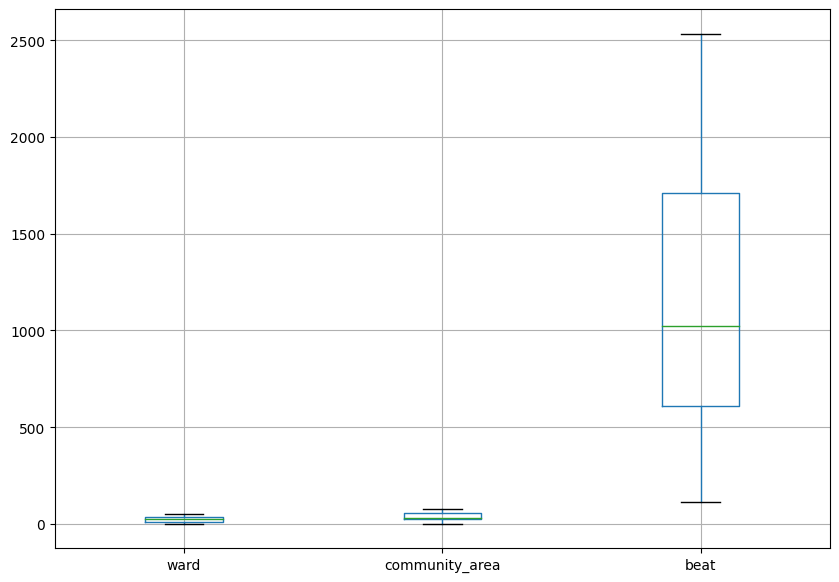

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 7))
crimes_df.boxplot(['ward','community_area','beat'])

##### Eliminating duplicate rows

In [7]:
crimes_df=crimes_df.drop_duplicates()

##### Handling missing values by dropping, replacing them 

<AxesSubplot: >

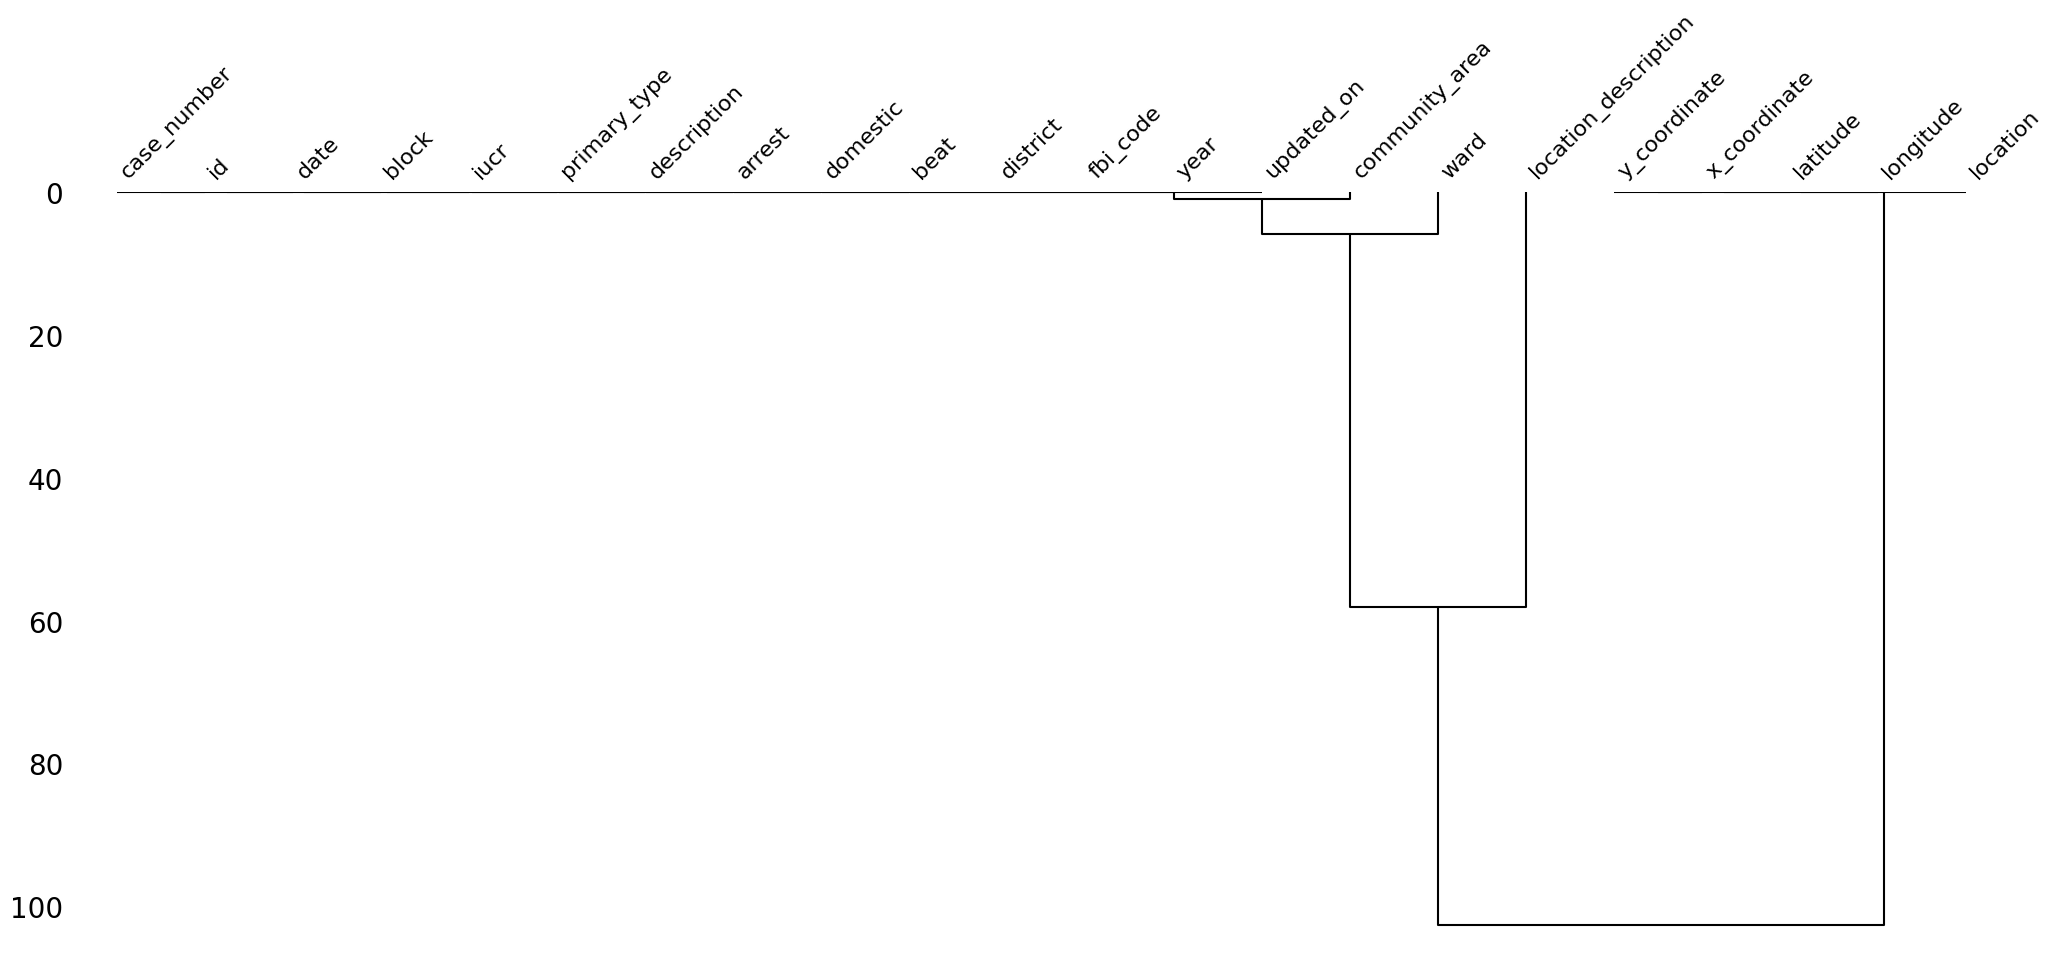

In [8]:
import missingno as msno 
msno.dendrogram(crimes_df)

In [9]:
crimes_df.dropna(subset = ['latitude','longitude','ward'], inplace = True)
crimes_df.reset_index(drop = True, inplace = True)
crimes_df['location_description'] = crimes_df['location_description'].fillna('Unavailable')

The x coordinate and y coordinate values are closely correlated with the null values of latitude and longitude, as can be seen from the dendogram above. If one of the values in this co-relation has a value of 1, it means that the other value likewise has a value of 1.

Therefore, it is safe to discard observations in which one of the values is zero. This shouldn't have an impact on our data and should also prevent the loss of significant observations.

##### Checking if there are any null values

In [10]:
crimes_df.isna().sum()

id                      0
case_number             0
date                    0
block                   0
iucr                    0
primary_type            0
description             0
location_description    0
arrest                  0
domestic                0
beat                    0
district                0
ward                    0
community_area          0
fbi_code                0
x_coordinate            0
y_coordinate            0
year                    0
updated_on              0
latitude                0
longitude               0
location                0
dtype: int64

In [11]:
# size of data after cleaning
crimes_df.size

14739450

### Predicting the type of crime going to happen in a location

## Decision tree Classifier

In [12]:
import matplotlib.pyplot as plt
import numpy as np
#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import tree

In [13]:
#Mapping similar crimes under one group.
primary_type_map = {
    ('BURGLARY','MOTOR VEHICLE THEFT','THEFT','ROBBERY') : 'THEFT',
    ('BATTERY','ASSAULT','NON-CRIMINAL','NON-CRIMINAL (SUBJECT SPECIFIED)') : 'NON-CRIMINAL_ASSAULT',
    ('CRIM SEXUAL ASSAULT','SEX OFFENSE','STALKING','PROSTITUTION') : 'SEXUAL_OFFENSE',
    ('WEAPONS VIOLATION','CONCEALED CARRY LICENSE VIOLATION') :  'WEAPONS_OFFENSE',
    ('HOMICIDE','CRIMINAL DAMAGE','DECEPTIVE PRACTICE','CRIMINAL TRESPASS') : 'CRIMINAL_OFFENSE',
    ('KIDNAPPING','HUMAN TRAFFICKING','OFFENSE INVOLVING CHILDREN') : 'HUMAN_TRAFFICKING_OFFENSE',
    ('NARCOTICS','OTHER NARCOTIC VIOLATION') : 'NARCOTIC_OFFENSE',
    ('OTHER OFFENSE','ARSON','GAMBLING','PUBLIC PEACE VIOLATION','INTIMIDATION','INTERFERENCE WITH PUBLIC OFFICER',
        'LIQUOR LAW VIOLATION','OBSCENITY','PUBLIC INDECENCY') : 'OTHER_OFFENSE'
}
primary_type_mapping = {}
for keys, values in primary_type_map.items():
    for key in keys:
        primary_type_mapping[key] = values
crimes_df['primary_type_grouped'] = crimes_df.primary_type.map(primary_type_mapping)

In [14]:
#Converting the numercial attributes to categorical attributes
crimes_df.year = pd.Categorical(crimes_df.year)
crimes_df.domestic = pd.Categorical(crimes_df.domestic)
crimes_df.arrest = pd.Categorical(crimes_df.arrest)
crimes_df.beat = pd.Categorical(crimes_df.beat)
crimes_df.district = pd.Categorical(crimes_df.district)
crimes_df.community_area = pd.Categorical(crimes_df.community_area)

In [15]:
# Making a new dataframe for the model with features used
crimes_data_type = crimes_df.loc[crimes_df.primary_type_grouped.isin(['THEFT','SEXUAL_OFFENSE','WEAPONS_OFFENSE'])]
crimes_data_type.head()



id case_number         date                 block iucr  \
0  11552667    JC100123  1/1/19 0:00      004XX N STATE ST  890   
1  11552674    JC100085  1/1/19 0:00    092XX S NORMAL AVE  910   
4  11553168    JC100745  1/1/19 0:00  008XX N MICHIGAN AVE  890   
6  11553495    JC101115  1/1/19 0:00    047XX N RACINE AVE  281   
9  11558163    JC106702  1/1/19 0:00    002XX W ONTARIO ST  890   

          primary_type     description location_description arrest domestic  \
0                THEFT   FROM BUILDING           RESTAURANT  False    False   
1  MOTOR VEHICLE THEFT      AUTOMOBILE               STREET  False    False   
4                THEFT   FROM BUILDING           RESTAURANT  False    False   
6  CRIM SEXUAL ASSAULT  NON-AGGRAVATED                OTHER  False    False   
9                THEFT   FROM BUILDING        BAR OR TAVERN  False    False   

   ... community_area fbi_code  x_coordinate y_coordinate  year  \
0  ...            8.0        6     1176302.0    1903096.0  2019   
1  ...           73.0        7     1174586.0    1843723.0  2019   
4  ...            8.0        6     1177330.0    1906499.0  2019   
6  ...            3.0        2     1167451.0    1931818.0  2019   
9  ...            8.0        6     1174469.0    1904439.0  2019   

      updated_on   latitude  longitude                       location  \
0  1/10/19 15:16  41.889453 -87.627995  (41.889453169, -87.627994833)   
1  1/10/19 15:16  41.726566 -87.636066  (41.726566477, -87.636065622)   
4  1/10/19 15:16  41.898768 -87.624116  (41.898767916, -87.624116333)   
6  1/10/19 15:16  41.968463 -87.659670  (41.968462892, -87.659670442)   
9  1/10/19 15:16  41.893180 -87.634686  (41.893179585, -87.634686145)   

   primary_type_grouped  
0                 THEFT  
1                 THEFT  
4                 THEFT  
6        SEXUAL_OFFENSE  
9                 THEFT  

[5 rows x 23 columns]

In [16]:
crimes_data_type['primary_type_grouped'] = crimes_data_type.primary_type_grouped.astype('category').cat.codes


C:\Users\syarla3\AppData\Local\Temp\ipykernel_10676\2508616501.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crimes_data_type['primary_type_grouped'] = crimes_data_type.primary_type_grouped.astype('category').cat.codes


In [17]:
crimes_data_type.head()

id case_number         date                 block iucr  \
0  11552667    JC100123  1/1/19 0:00      004XX N STATE ST  890   
1  11552674    JC100085  1/1/19 0:00    092XX S NORMAL AVE  910   
4  11553168    JC100745  1/1/19 0:00  008XX N MICHIGAN AVE  890   
6  11553495    JC101115  1/1/19 0:00    047XX N RACINE AVE  281   
9  11558163    JC106702  1/1/19 0:00    002XX W ONTARIO ST  890   

          primary_type     description location_description arrest domestic  \
0                THEFT   FROM BUILDING           RESTAURANT  False    False   
1  MOTOR VEHICLE THEFT      AUTOMOBILE               STREET  False    False   
4                THEFT   FROM BUILDING           RESTAURANT  False    False   
6  CRIM SEXUAL ASSAULT  NON-AGGRAVATED                OTHER  False    False   
9                THEFT   FROM BUILDING        BAR OR TAVERN  False    False   

   ... community_area fbi_code  x_coordinate y_coordinate  year  \
0  ...            8.0        6     1176302.0    1903096.0  2019   
1  ...           73.0        7     1174586.0    1843723.0  2019   
4  ...            8.0        6     1177330.0    1906499.0  2019   
6  ...            3.0        2     1167451.0    1931818.0  2019   
9  ...            8.0        6     1174469.0    1904439.0  2019   

      updated_on   latitude  longitude                       location  \
0  1/10/19 15:16  41.889453 -87.627995  (41.889453169, -87.627994833)   
1  1/10/19 15:16  41.726566 -87.636066  (41.726566477, -87.636065622)   
4  1/10/19 15:16  41.898768 -87.624116  (41.898767916, -87.624116333)   
6  1/10/19 15:16  41.968463 -87.659670  (41.968462892, -87.659670442)   
9  1/10/19 15:16  41.893180 -87.634686  (41.893179585, -87.634686145)   

   primary_type_grouped  
0                     1  
1                     1  
4                     1  
6                     0  
9                     1  

[5 rows x 23 columns]

In [18]:
# Dropping unnecessary columns which are not required for this prediction  
crimes_data_prediction = crimes_data_type.drop(['id','case_number','location','date','block','iucr','description',
    'location_description','primary_type','fbi_code','updated_on','x_coordinate','y_coordinate','primary_type_grouped'],axis=1)


In [19]:
crimes_data_prediction_type=crimes_data_type[['primary_type_grouped']]

In [20]:
crimes_data_prediction_type.head()

primary_type_grouped
0                     1
1                     1
4                     1
6                     0
9                     1

In [21]:
crimes_data_prediction.head()

arrest domestic  beat district  ward community_area  year   latitude  \
0  False    False  1831       18  42.0            8.0  2019  41.889453   
1  False    False  2223       22  21.0           73.0  2019  41.726566   
4  False    False  1833       18   2.0            8.0  2019  41.898768   
6  False    False  1913       19  46.0            3.0  2019  41.968463   
9  False    False  1831       18  42.0            8.0  2019  41.893180   

   longitude  
0 -87.627995  
1 -87.636066  
4 -87.624116  
6 -87.659670  
9 -87.634686

In [22]:
crimes_data_prediction_type.head()

primary_type_grouped
0                     1
1                     1
4                     1
6                     0
9                     1

In [23]:
crimes_data_prediction=crimes_data_prediction.to_numpy()
crimes_data_prediction_type=crimes_data_prediction_type.to_numpy()

##### Keeping grouped primary type of crime as target feature (i.e crimes_data_prediction_type)

In [24]:
# Spliting the data into training and testing where test size as 30%
XX_train, XX_test, yy_train, yy_test = train_test_split(crimes_data_prediction,crimes_data_prediction_type, test_size=0.3, random_state=42)

In [25]:
XX_train.shape,XX_test.shape,yy_test.shape,yy_train.shape

((174488, 9), (74781, 9), (74781, 1), (174488, 1))

In [26]:
# Using the model from sklearn and fitting it.

model = tree.DecisionTreeClassifier(criterion = "entropy", random_state = 42)
model.fit(XX_train, yy_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [27]:
# Making predictions
yy_pred = model.predict(XX_test)

In [28]:
#Classification Metrics
from sklearn.metrics import confusion_matrix
print('Accuracy = ',metrics.accuracy_score(yy_test, yy_pred))
print('Error = ',1 - metrics.accuracy_score(yy_test, yy_pred))
print('Classification Report\n',metrics.classification_report(yy_test, yy_pred))
confusion_matrixx=confusion_matrix(yy_test,yy_pred)


Accuracy =  0.877816557681764
Error =  0.12218344231823597
Classification Report
               precision    recall  f1-score   support

           0       0.21      0.23      0.22      1830
           1       0.93      0.93      0.93     65663
           2       0.56      0.53      0.55      7288

    accuracy                           0.88     74781
   macro avg       0.57      0.57      0.57     74781
weighted avg       0.88      0.88      0.88     74781



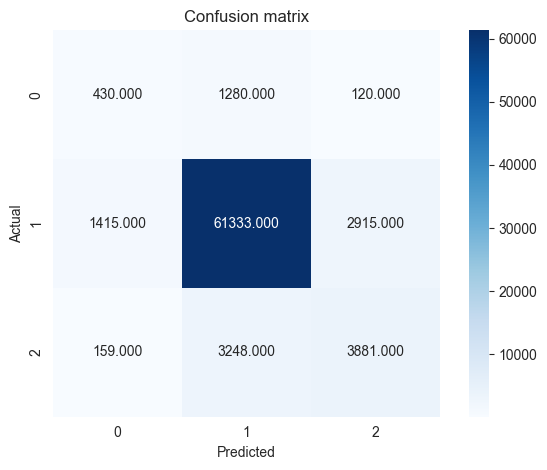

In [29]:
#Visualization of Confusion Matrix
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")
sns.heatmap(confusion_matrixx, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

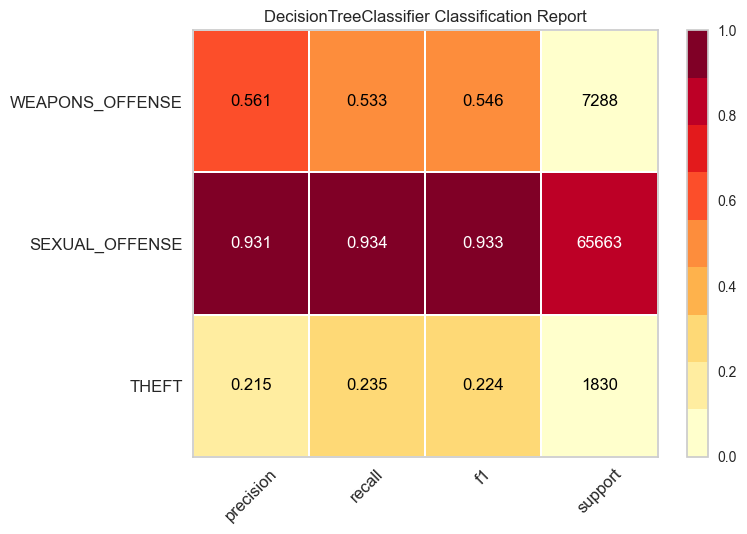

<AxesSubplot: title={'center': 'DecisionTreeClassifier Classification Report'}>

In [30]:
from yellowbrick.classifier import ClassificationReport
classes=['THEFT','SEXUAL_OFFENSE','WEAPONS_OFFENSE']

visualizer = ClassificationReport(model, classes=classes, support=True)

visualizer.fit(XX_train, yy_train)        # Fit the visualizer and the model
visualizer.score(XX_test, yy_test)        # Evaluate the model on the test data
visualizer.show() 

## Observation: By classification report,
- Precision: In the case where theft was predicted as positive 21% were correctly predicted. 
- Recall: In the case of an sexual_offense 93% were classified correctly when an actual arrest happened.
- f1: The weighted harmonic mean of precision and recall is a good value if its closer to 1 and this is almost close to 1 in this case.So it a good model.
- Support: This shows the number of actual occurences of the classes in teh dataset we see that we have 1830 instances of theft whereas 65663 instances of sexual_offense and 7288 instances of weapon offense.

### Accuracy for Decision tree classifier : 88%

### Making a visualization to show comparision between actual value and predicted value

#### using test data to make visualizion 

In [31]:
type(XX_test)

numpy.ndarray

In [32]:
columnna=['arrest',	'domestic','beat'	,'district',	'ward',	'community_area',	'year',	'latitude',	'longitude']
df=pd.DataFrame(data = XX_test,columns=columnna)

In [33]:
df['predicted']=yy_pred
df

arrest domestic  beat district  ward community_area  year   latitude  \
0      False    False  1624       16  38.0           15.0  2019  41.960531   
1      False    False   111        1  42.0           32.0  2019  41.883223   
2       True    False   821        8  14.0           57.0  2020  41.812611   
3      False    False   923        9  14.0           63.0  2020  41.800582   
4      False    False  1021       10  24.0           29.0  2020  41.866342   
...      ...      ...   ...      ...   ...            ...   ...        ...   
74776  False    False   212        2   3.0           35.0  2021  41.828307   
74777  False    False   823        8  16.0           66.0  2021  41.781728   
74778  False    False  1212       12   1.0           24.0  2021  41.902438   
74779  False    False  2011       20  40.0            4.0  2019  41.983119   
74780  False    False  1915       19  46.0            3.0  2020  41.961379   

       longitude  predicted  
0     -87.763257          0  
1     -87.625603          1  
2     -87.723765          1  
3     -87.684211          1  
4     -87.711154          1  
...          ...        ...  
74776 -87.619274          1  
74777 -87.700779          1  
74778 -87.687012          1  
74779 -87.700022          1  
74780 -87.654741          1  

[74781 rows x 10 columns]

making a geographical scatter plot 

C:\Users\syarla3\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\seaborn\regression.py:582: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


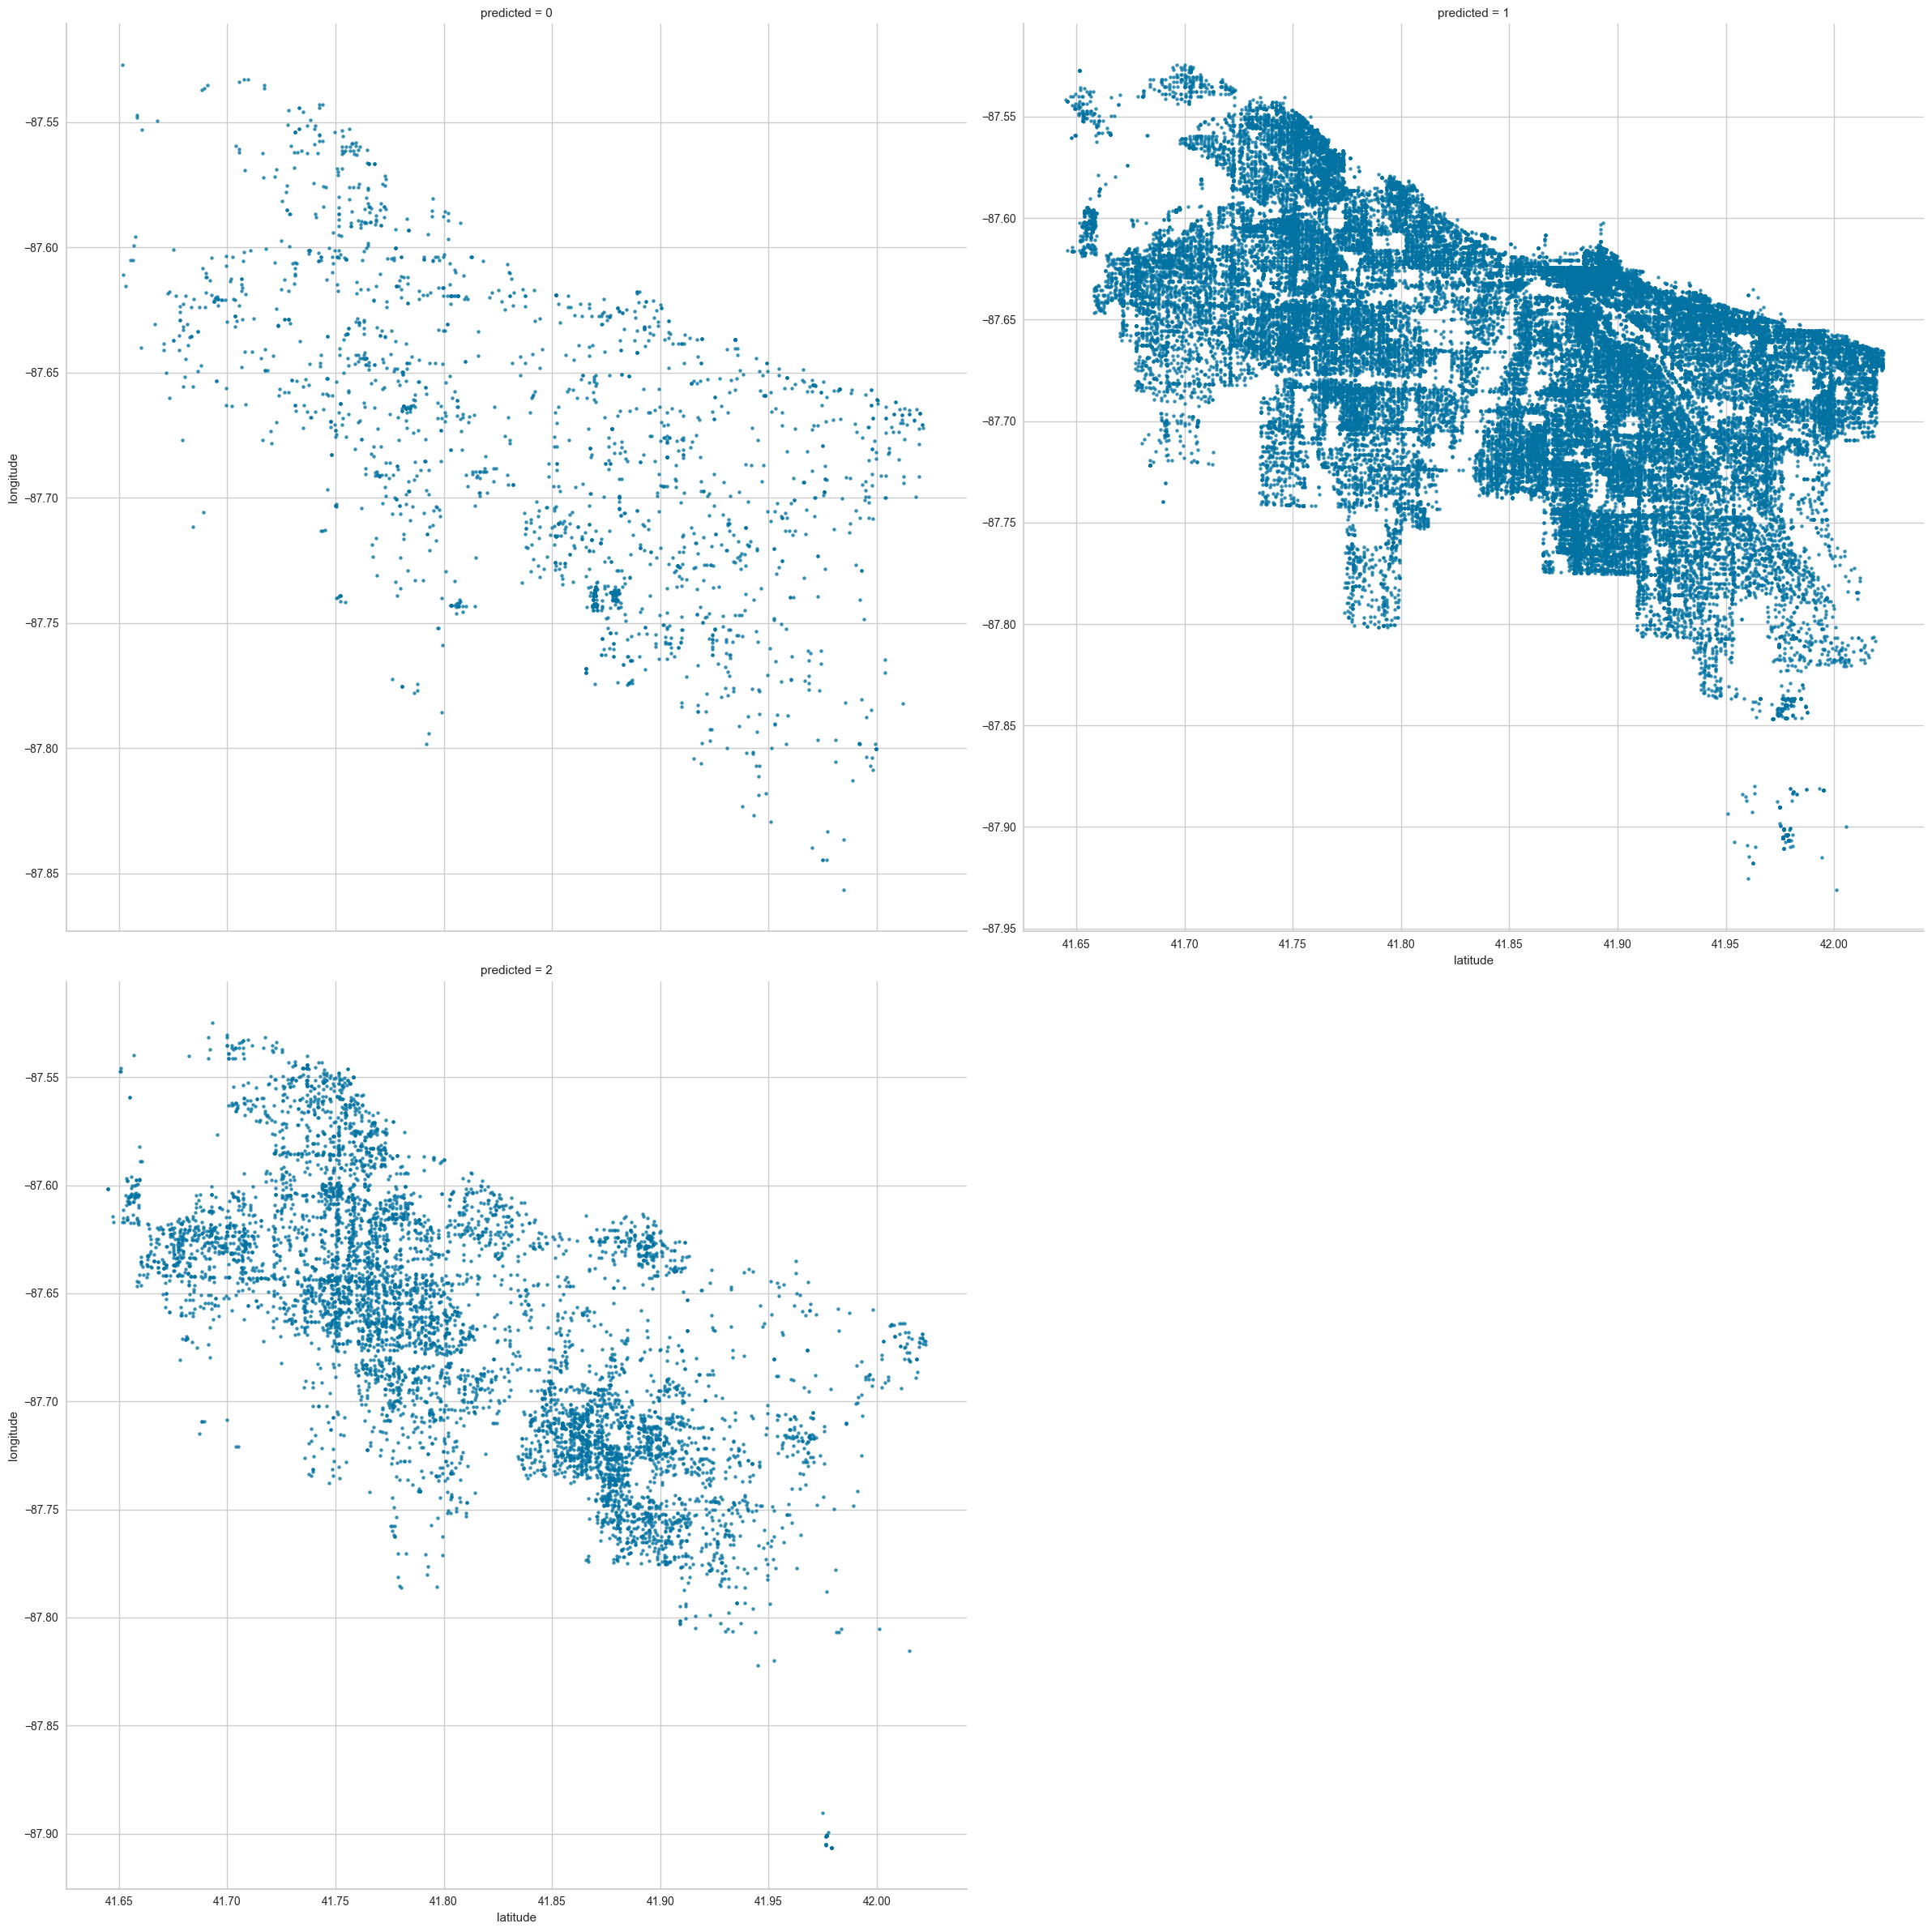

In [34]:
g = sns.lmplot(x='latitude',
               y='longitude',
               col="predicted",
               data=df,
               col_wrap=2,
                fit_reg=False,
                height=12,
                ci=2,
                sharey=False,
               scatter_kws={"marker": "D",
                            "s": 10})

#### using actual data to make same visualization 

In [35]:
import pandas as pd
columnna=['arrest',	'domestic','beat'	,'district',	'ward',	'community_area',	'year',	'latitude',	'longitude']
df=pd.DataFrame(data =crimes_data_prediction ,columns=columnna)

In [36]:
df['primary_tyoe_gr']=crimes_data_prediction_type
df

arrest domestic  beat district  ward community_area  year   latitude  \
0       False    False  1831       18  42.0            8.0  2019  41.889453   
1       False    False  2223       22  21.0           73.0  2019  41.726566   
2       False    False  1833       18   2.0            8.0  2019  41.898768   
3       False    False  1913       19  46.0            3.0  2019  41.968463   
4       False    False  1831       18  42.0            8.0  2019   41.89318   
...       ...      ...   ...      ...   ...            ...   ...        ...   
249264  False    False  1622       16  45.0           11.0  2021  41.970845   
249265  False    False  2031       20  40.0            4.0  2021  41.971013   
249266  False    False   621        6  17.0           69.0  2021   41.75542   
249267  False    False  1414       14   1.0           22.0  2021  41.918509   
249268  False    False  1232       12  27.0           28.0  2021  41.881751   

        longitude  primary_tyoe_gr  
0      -87.627995                1  
1      -87.636066                1  
2      -87.624116                1  
3       -87.65967                0  
4      -87.634686                1  
...           ...              ...  
249264 -87.775852                1  
249265 -87.686558                1  
249266 -87.638363                1  
249267 -87.700544                1  
249268  -87.64904                1  

[249269 rows x 10 columns]

making a geographical scatter plot

C:\Users\syarla3\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\seaborn\regression.py:582: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


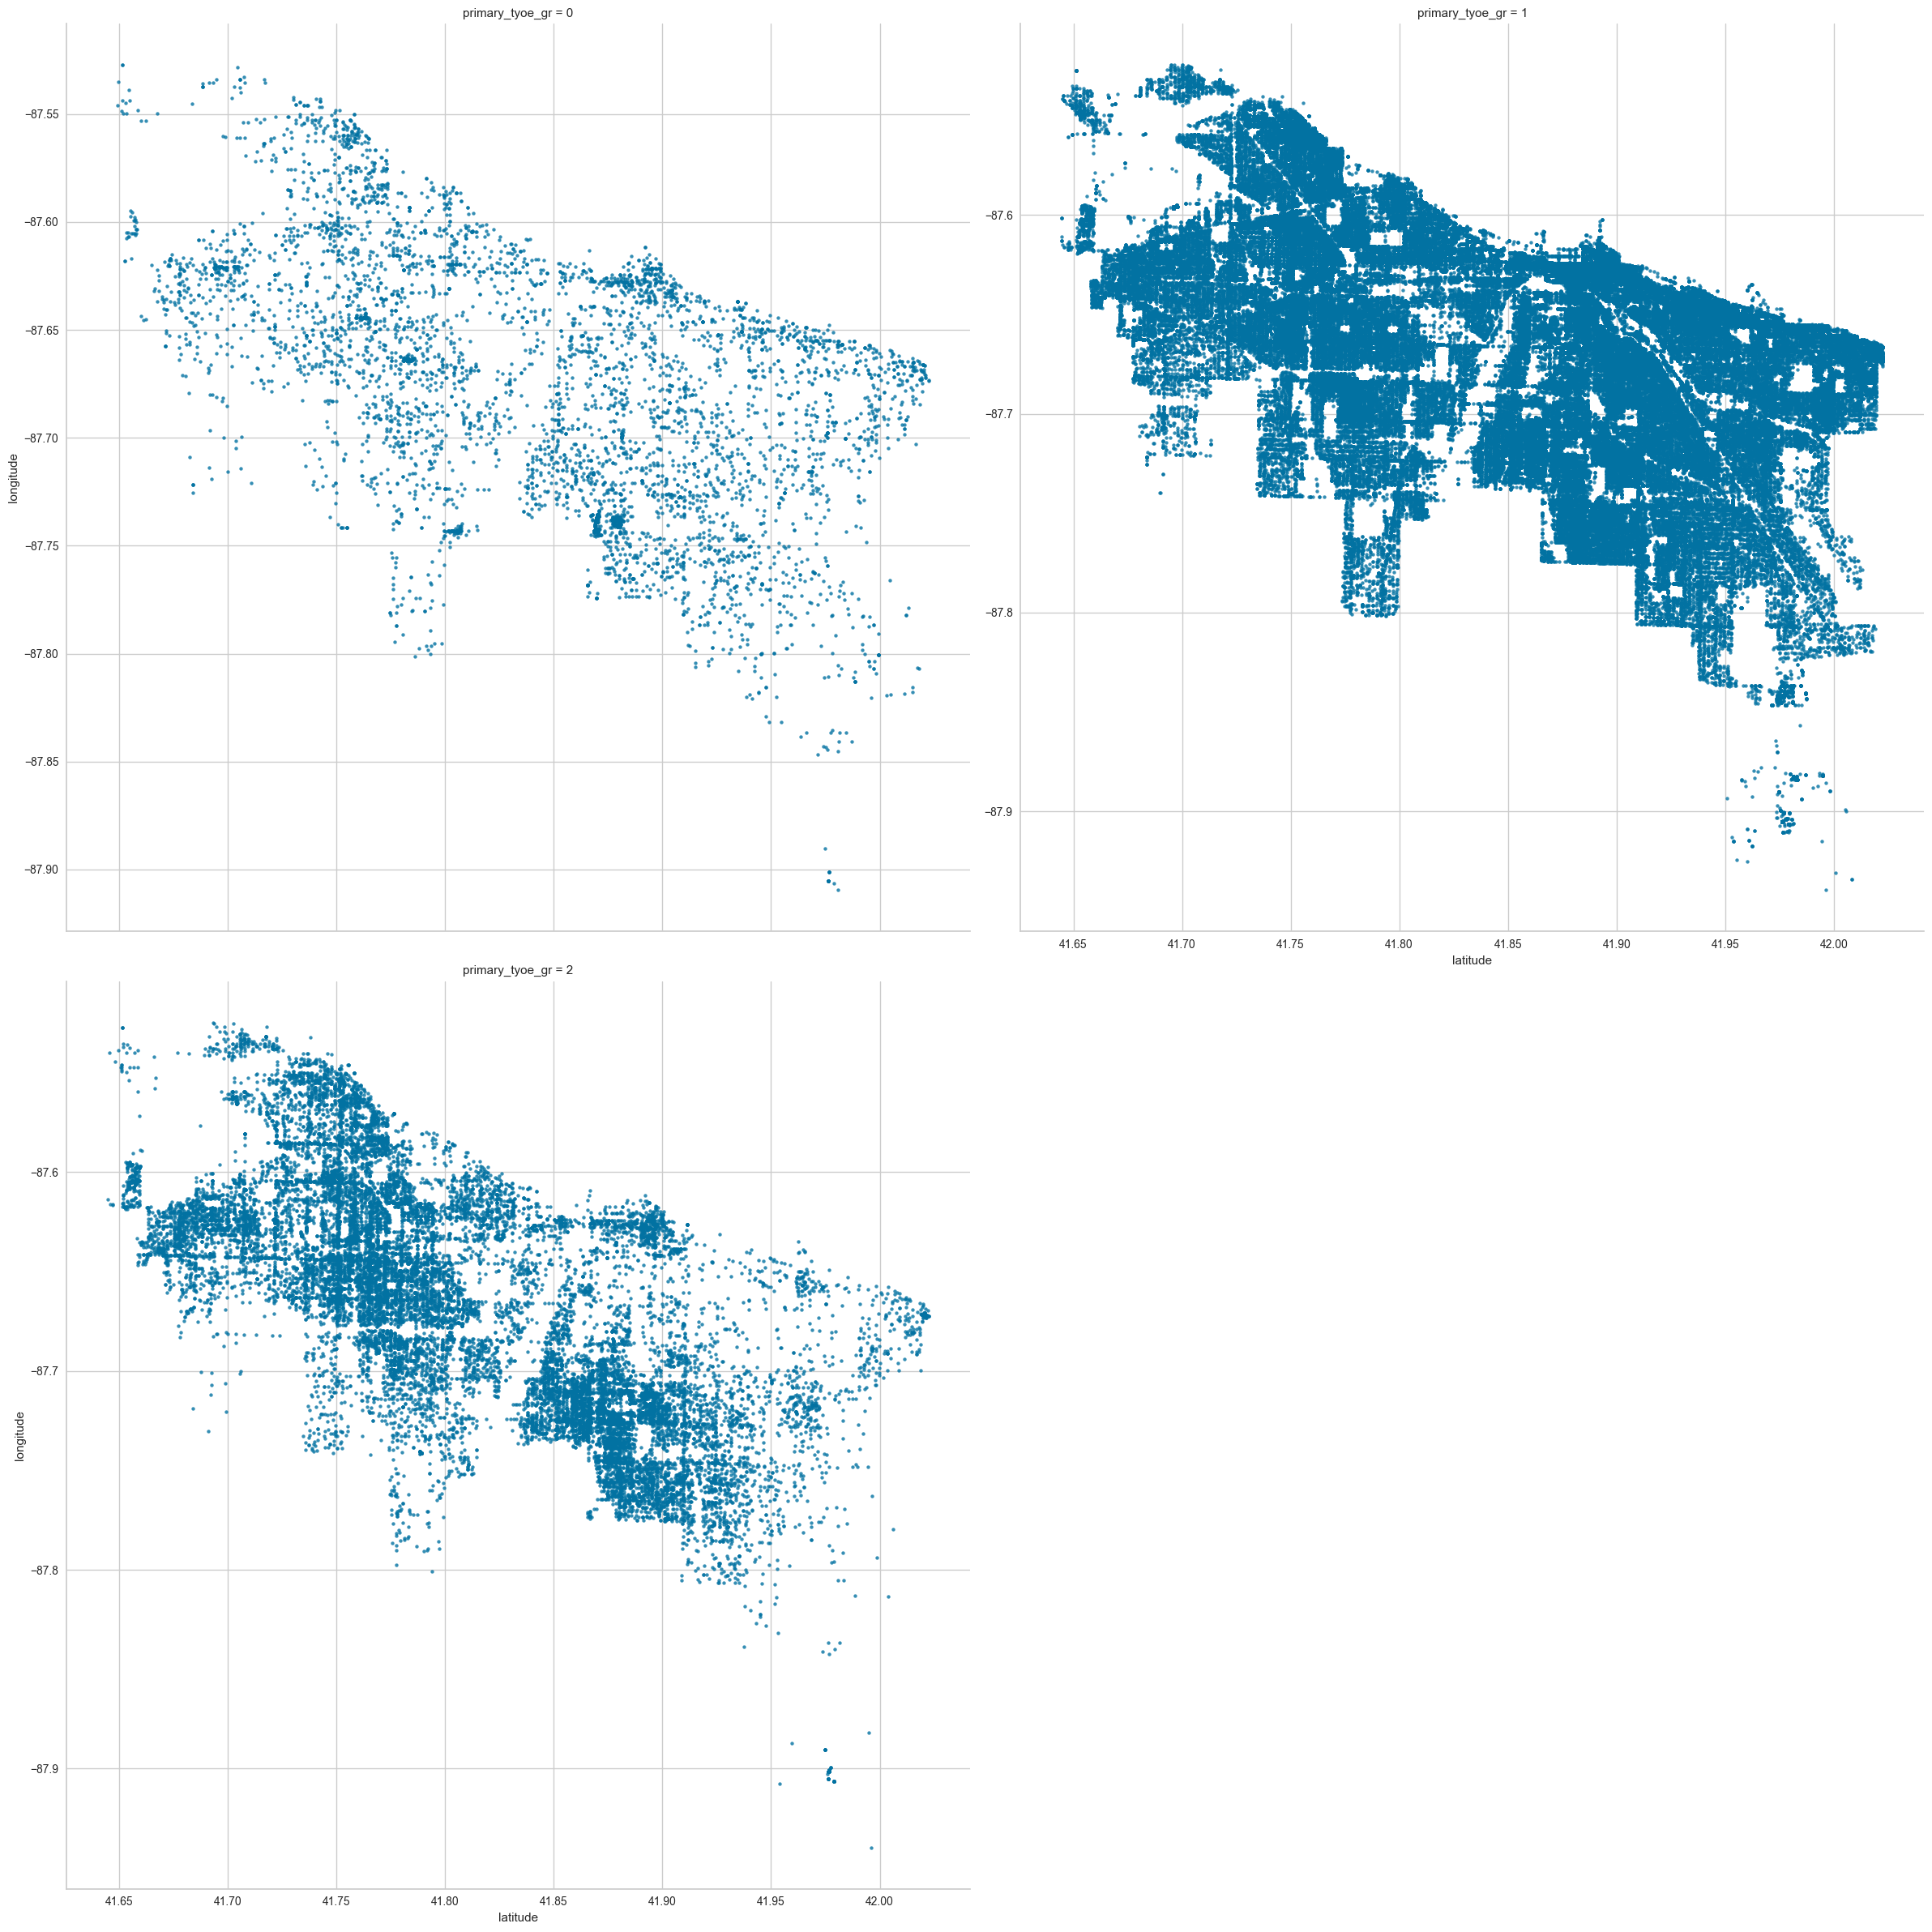

In [37]:
g = sns.lmplot(x='latitude',
               y='longitude',
               col="primary_tyoe_gr",
               data=df,
               col_wrap=2,
                fit_reg=False,
                height=12,
                ci=2,
                sharey=False,
               scatter_kws={"marker": "D",
                            "s": 10})

Observation: As both of the visualizations are almost same which means model is performing good in predicting

## Random Forest Classifier

In [38]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import tree


##### Importing the dataset

In [39]:
crimes_df = pd.read_csv('Crimes-2019_to_2021.csv')
crimes_df.head(5)

ID Case Number         Date                   Block  IUCR  \
0  11552667    JC100123  1/1/19 0:00        004XX N STATE ST   890   
1  11552674    JC100085  1/1/19 0:00      092XX S NORMAL AVE   910   
2  11552709    JC100020  1/1/19 0:00   044XX S WASHTENAW AVE   486   
3  11552758    JC100058  1/1/19 0:00  063XX S MARSHFIELD AVE  1310   
4  11553168    JC100745  1/1/19 0:00    008XX N MICHIGAN AVE   890   

          Primary Type              Description Location Description  Arrest  \
0                THEFT            FROM BUILDING           RESTAURANT   False   
1  MOTOR VEHICLE THEFT               AUTOMOBILE               STREET   False   
2              BATTERY  DOMESTIC BATTERY SIMPLE            APARTMENT   False   
3      CRIMINAL DAMAGE              TO PROPERTY            APARTMENT   False   
4                THEFT            FROM BUILDING           RESTAURANT   False   

   Domestic  ...  Ward  Community Area  FBI Code  X Coordinate Y Coordinate  \
0     False  ...  42.0             8.0         6     1176302.0    1903096.0   
1     False  ...  21.0            73.0         7     1174586.0    1843723.0   
2      True  ...  15.0            58.0       08B     1159112.0    1875020.0   
3     False  ...  16.0            67.0        14     1166414.0    1862607.0   
4     False  ...   2.0             8.0         6     1177330.0    1906499.0   

   Year     Updated On   Latitude  Longitude                       Location  
0  2019  1/10/19 15:16  41.889453 -87.627995  (41.889453169, -87.627994833)  
1  2019  1/10/19 15:16  41.726566 -87.636066  (41.726566477, -87.636065622)  
2  2019  1/10/19 15:16  41.812780 -87.691894  (41.812780011, -87.691893746)  
3  2019  1/10/19 15:16  41.778565 -87.665464   (41.77856457, -87.665463557)  
4  2019  1/10/19 15:16  41.898768 -87.624116  (41.898767916, -87.624116333)  

[5 rows x 22 columns]

##### Converting the column names to a standard form and handling inconsistencies

In [40]:
crimes_df.columns =crimes_df.columns.str.strip()
crimes_df.columns = crimes_df.columns.str.replace(' ', '_')
crimes_df.columns = crimes_df.columns.str.lower()

##### Eliminating duplicate rows

In [41]:
crimes_df=crimes_df.drop_duplicates()

##### Handling missing values by dropping, replacing them 

In [42]:
crimes_df.dropna(subset = ['latitude','longitude','ward'], inplace = True)
crimes_df.reset_index(drop = True, inplace = True)
crimes_df['location_description'] = crimes_df['location_description'].fillna('Unavailable')

##### Checking if there are any null values

In [43]:
crimes_df.isna().sum()

id                      0
case_number             0
date                    0
block                   0
iucr                    0
primary_type            0
description             0
location_description    0
arrest                  0
domestic                0
beat                    0
district                0
ward                    0
community_area          0
fbi_code                0
x_coordinate            0
y_coordinate            0
year                    0
updated_on              0
latitude                0
longitude               0
location                0
dtype: int64

In [44]:
#Mapping similar crimes under one group.
primary_type_map = {
    ('BURGLARY','MOTOR VEHICLE THEFT','THEFT','ROBBERY') : 'THEFT',
    ('BATTERY','ASSAULT','NON-CRIMINAL','NON-CRIMINAL (SUBJECT SPECIFIED)') : 'NON-CRIMINAL_ASSAULT',
    ('CRIM SEXUAL ASSAULT','SEX OFFENSE','STALKING','PROSTITUTION') : 'SEXUAL_OFFENSE',
    ('WEAPONS VIOLATION','CONCEALED CARRY LICENSE VIOLATION') :  'WEAPONS_OFFENSE',
    ('HOMICIDE','CRIMINAL DAMAGE','DECEPTIVE PRACTICE','CRIMINAL TRESPASS') : 'CRIMINAL_OFFENSE',
    ('KIDNAPPING','HUMAN TRAFFICKING','OFFENSE INVOLVING CHILDREN') : 'HUMAN_TRAFFICKING_OFFENSE',
    ('NARCOTICS','OTHER NARCOTIC VIOLATION') : 'NARCOTIC_OFFENSE',
    ('OTHER OFFENSE','ARSON','GAMBLING','PUBLIC PEACE VIOLATION','INTIMIDATION','INTERFERENCE WITH PUBLIC OFFICER',
        'LIQUOR LAW VIOLATION','OBSCENITY','PUBLIC INDECENCY') : 'OTHER_OFFENSE'
}
primary_type_mapping = {}
for keys, values in primary_type_map.items():
    for key in keys:
        primary_type_mapping[key] = values
crimes_df['primary_type_grouped'] = crimes_df.primary_type.map(primary_type_mapping)

In [45]:
#Converting the numercial attributes to categorical attributes
crimes_df.year = pd.Categorical(crimes_df.year)
crimes_df.domestic = pd.Categorical(crimes_df.domestic)
crimes_df.arrest = pd.Categorical(crimes_df.arrest)
crimes_df.beat = pd.Categorical(crimes_df.beat)
crimes_df.district = pd.Categorical(crimes_df.district)
crimes_df.community_area = pd.Categorical(crimes_df.community_area)

In [46]:
# Making a new dataframe for the model with features used
crimes_data_type = crimes_df.loc[crimes_df.primary_type_grouped.isin(['THEFT','SEXUAL_OFFENSE','WEAPONS_OFFENSE'])]
crimes_data_type.head()


id case_number         date                 block iucr  \
0  11552667    JC100123  1/1/19 0:00      004XX N STATE ST  890   
1  11552674    JC100085  1/1/19 0:00    092XX S NORMAL AVE  910   
4  11553168    JC100745  1/1/19 0:00  008XX N MICHIGAN AVE  890   
6  11553495    JC101115  1/1/19 0:00    047XX N RACINE AVE  281   
9  11558163    JC106702  1/1/19 0:00    002XX W ONTARIO ST  890   

          primary_type     description location_description arrest domestic  \
0                THEFT   FROM BUILDING           RESTAURANT  False    False   
1  MOTOR VEHICLE THEFT      AUTOMOBILE               STREET  False    False   
4                THEFT   FROM BUILDING           RESTAURANT  False    False   
6  CRIM SEXUAL ASSAULT  NON-AGGRAVATED                OTHER  False    False   
9                THEFT   FROM BUILDING        BAR OR TAVERN  False    False   

   ... community_area fbi_code  x_coordinate y_coordinate  year  \
0  ...            8.0        6     1176302.0    1903096.0  2019   
1  ...           73.0        7     1174586.0    1843723.0  2019   
4  ...            8.0        6     1177330.0    1906499.0  2019   
6  ...            3.0        2     1167451.0    1931818.0  2019   
9  ...            8.0        6     1174469.0    1904439.0  2019   

      updated_on   latitude  longitude                       location  \
0  1/10/19 15:16  41.889453 -87.627995  (41.889453169, -87.627994833)   
1  1/10/19 15:16  41.726566 -87.636066  (41.726566477, -87.636065622)   
4  1/10/19 15:16  41.898768 -87.624116  (41.898767916, -87.624116333)   
6  1/10/19 15:16  41.968463 -87.659670  (41.968462892, -87.659670442)   
9  1/10/19 15:16  41.893180 -87.634686  (41.893179585, -87.634686145)   

   primary_type_grouped  
0                 THEFT  
1                 THEFT  
4                 THEFT  
6        SEXUAL_OFFENSE  
9                 THEFT  

[5 rows x 23 columns]

In [47]:
crimes_data_type['primary_type_grouped'] = crimes_data_type.primary_type_grouped.astype('category').cat.codes

C:\Users\syarla3\AppData\Local\Temp\ipykernel_10676\3410947807.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crimes_data_type['primary_type_grouped'] = crimes_data_type.primary_type_grouped.astype('category').cat.codes


In [48]:
crimes_data_type.head()

id case_number         date                 block iucr  \
0  11552667    JC100123  1/1/19 0:00      004XX N STATE ST  890   
1  11552674    JC100085  1/1/19 0:00    092XX S NORMAL AVE  910   
4  11553168    JC100745  1/1/19 0:00  008XX N MICHIGAN AVE  890   
6  11553495    JC101115  1/1/19 0:00    047XX N RACINE AVE  281   
9  11558163    JC106702  1/1/19 0:00    002XX W ONTARIO ST  890   

          primary_type     description location_description arrest domestic  \
0                THEFT   FROM BUILDING           RESTAURANT  False    False   
1  MOTOR VEHICLE THEFT      AUTOMOBILE               STREET  False    False   
4                THEFT   FROM BUILDING           RESTAURANT  False    False   
6  CRIM SEXUAL ASSAULT  NON-AGGRAVATED                OTHER  False    False   
9                THEFT   FROM BUILDING        BAR OR TAVERN  False    False   

   ... community_area fbi_code  x_coordinate y_coordinate  year  \
0  ...            8.0        6     1176302.0    1903096.0  2019   
1  ...           73.0        7     1174586.0    1843723.0  2019   
4  ...            8.0        6     1177330.0    1906499.0  2019   
6  ...            3.0        2     1167451.0    1931818.0  2019   
9  ...            8.0        6     1174469.0    1904439.0  2019   

      updated_on   latitude  longitude                       location  \
0  1/10/19 15:16  41.889453 -87.627995  (41.889453169, -87.627994833)   
1  1/10/19 15:16  41.726566 -87.636066  (41.726566477, -87.636065622)   
4  1/10/19 15:16  41.898768 -87.624116  (41.898767916, -87.624116333)   
6  1/10/19 15:16  41.968463 -87.659670  (41.968462892, -87.659670442)   
9  1/10/19 15:16  41.893180 -87.634686  (41.893179585, -87.634686145)   

   primary_type_grouped  
0                     1  
1                     1  
4                     1  
6                     0  
9                     1  

[5 rows x 23 columns]

In [49]:
# Dropping unnecessary columns which are not required for this prediction  
crimes_data_prediction = crimes_data_type.drop(['id','case_number','location','date','block','iucr','description',
'location_description','primary_type','fbi_code','updated_on','x_coordinate','y_coordinate','primary_type_grouped'],axis=1)

In [50]:
crimes_data_prediction_type=crimes_data_type[['primary_type_grouped']]

In [51]:
crimes_data_prediction=crimes_data_prediction.to_numpy()
crimes_data_prediction_type=crimes_data_prediction_type.to_numpy()

In [52]:
# Spliting the data into training and testing where test size as 30%
XX_train, XX_test, yy_train, yy_test = train_test_split(crimes_data_prediction,crimes_data_prediction_type, test_size=0.3, random_state=42)

In [53]:
from sklearn.ensemble import RandomForestClassifier
modell = RandomForestClassifier(n_estimators = 10,criterion='entropy',random_state=42)
modell.fit(XX_train,yy_train)

C:\Users\syarla3\AppData\Local\Temp\ipykernel_10676\12668443.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modell.fit(XX_train,yy_train)


RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=42)

In [54]:
yy_pred = modell.predict(XX_test)

In [55]:
#Classification Metrics
from sklearn.metrics import confusion_matrix
print('Accuracy = ',metrics.accuracy_score(yy_test, yy_pred))
print('Error = ',1 - metrics.accuracy_score(yy_test, yy_pred))
print('Classification Report\n',metrics.classification_report(yy_test, yy_pred))
confusion_matrixx = confusion_matrix(yy_test, yy_pred)

Accuracy =  0.9048287666653294
Error =  0.09517123333467059
Classification Report
               precision    recall  f1-score   support

           0       0.34      0.20      0.26      1830
           1       0.93      0.96      0.95     65663
           2       0.69      0.54      0.60      7288

    accuracy                           0.90     74781
   macro avg       0.66      0.57      0.60     74781
weighted avg       0.89      0.90      0.90     74781



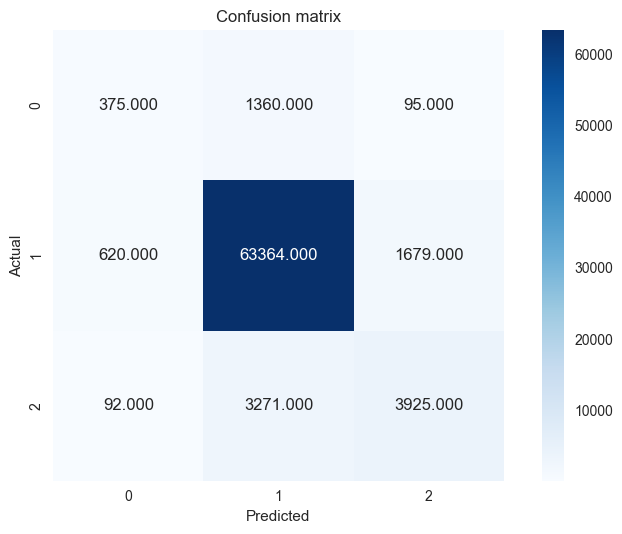

In [56]:
#Visualization of Confusion Matrix
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")
sns.heatmap(confusion_matrixx, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

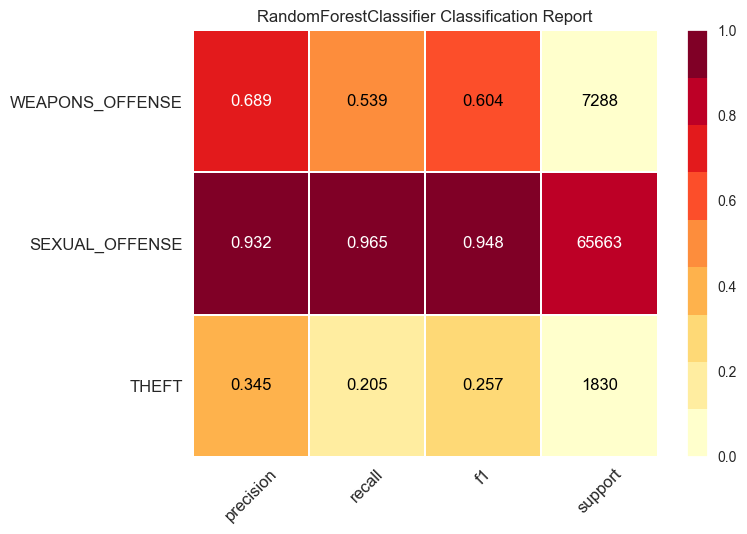

<AxesSubplot: title={'center': 'RandomForestClassifier Classification Report'}>

In [57]:
from yellowbrick.classifier import ClassificationReport
classes=['THEFT','SEXUAL_OFFENSE','WEAPONS_OFFENSE']

visualizer = ClassificationReport(modell, classes=classes, support=True)

visualizer.fit(XX_train, yy_train)        # Fit the visualizer and the model
visualizer.score(XX_test, yy_test)        # Evaluate the model on the test data
visualizer.show() 

## Observation: By classification report,
- Precision: In the case where theft was predicted as positive 34% were correctly predicted. 
- Recall: In the case of an sexual_offense 96% were classified correctly when an actual arrest happened.
- f1: The weighted harmonic mean of precision and recall is a good value if its closer to 1 and this is almost close to 1 in this case.So it a good model.
- Support: This shows the number of actual occurences of the classes in teh dataset we see that we have 1830 instances of theft whereas 65663 instances of sexual_offense and 7288 instances of weapon offense.

By using Random Forest machine learnng model the accuracy is increased when compared to Decision tree classifier.

### Making a visualization to show comparision between actual value and predicted value

#### using test data to make visualizion 

In [58]:
type(XX_test)

numpy.ndarray

In [59]:
columnna=['arrest',	'domestic','beat'	,'district',	'ward',	'community_area',	'year',	'latitude',	'longitude']
df=pd.DataFrame(data = XX_test,columns=columnna)

In [60]:
df['predicted']=yy_pred
df

arrest domestic  beat district  ward community_area  year   latitude  \
0      False    False  1624       16  38.0           15.0  2019  41.960531   
1      False    False   111        1  42.0           32.0  2019  41.883223   
2       True    False   821        8  14.0           57.0  2020  41.812611   
3      False    False   923        9  14.0           63.0  2020  41.800582   
4      False    False  1021       10  24.0           29.0  2020  41.866342   
...      ...      ...   ...      ...   ...            ...   ...        ...   
74776  False    False   212        2   3.0           35.0  2021  41.828307   
74777  False    False   823        8  16.0           66.0  2021  41.781728   
74778  False    False  1212       12   1.0           24.0  2021  41.902438   
74779  False    False  2011       20  40.0            4.0  2019  41.983119   
74780  False    False  1915       19  46.0            3.0  2020  41.961379   

       longitude  predicted  
0     -87.763257          1  
1     -87.625603          1  
2     -87.723765          1  
3     -87.684211          1  
4     -87.711154          1  
...          ...        ...  
74776 -87.619274          1  
74777 -87.700779          1  
74778 -87.687012          1  
74779 -87.700022          1  
74780 -87.654741          1  

[74781 rows x 10 columns]

making a geographical scatter plot 

C:\Users\syarla3\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\seaborn\regression.py:582: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


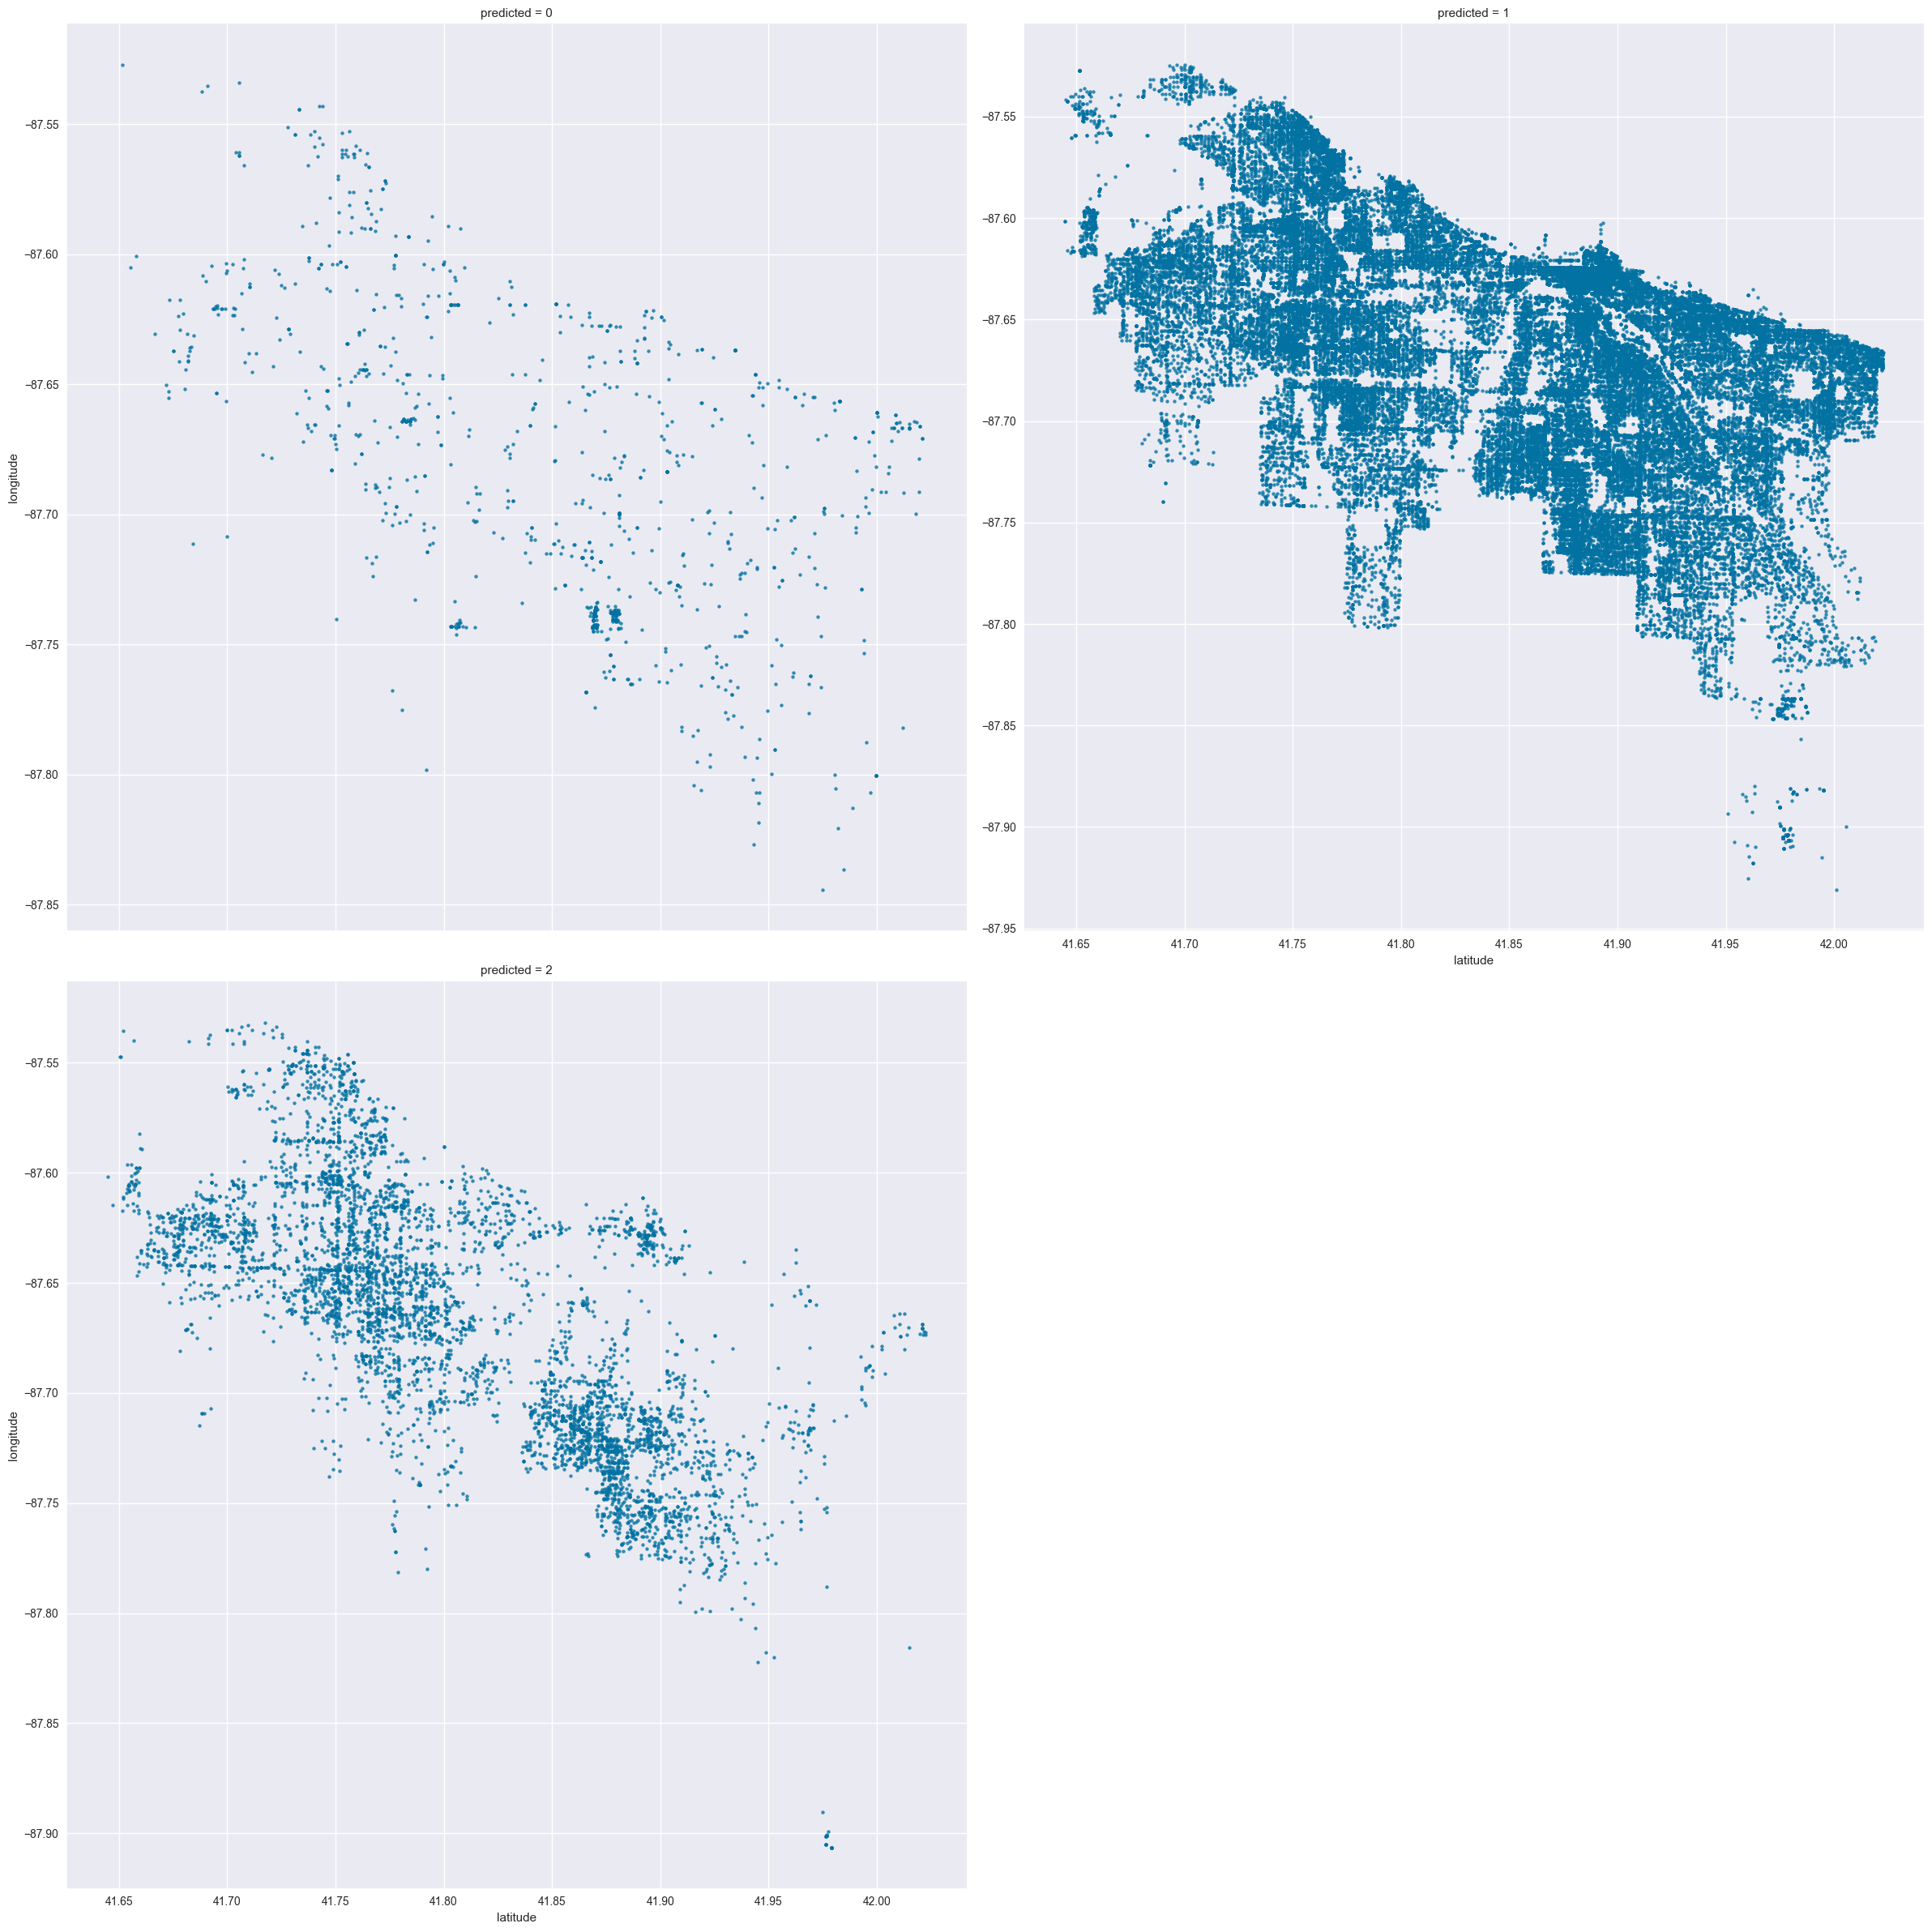

In [61]:
g = sns.lmplot(x='latitude',
               y='longitude',
               col="predicted",
               data=df,
               col_wrap=2,
                fit_reg=False,
                height=12,
                ci=2,
                sharey=False,
               scatter_kws={"marker": "D",
                            "s": 10})

#### using actual data to make same visualization 

In [62]:
import pandas as pd
columnna=['arrest',	'domestic','beat'	,'district',	'ward',	'community_area',	'year',	'latitude',	'longitude']
df=pd.DataFrame(data =crimes_data_prediction ,columns=columnna)

In [63]:
df['primary_tyoe_gr']=crimes_data_prediction_type
df

arrest domestic  beat district  ward community_area  year   latitude  \
0       False    False  1831       18  42.0            8.0  2019  41.889453   
1       False    False  2223       22  21.0           73.0  2019  41.726566   
2       False    False  1833       18   2.0            8.0  2019  41.898768   
3       False    False  1913       19  46.0            3.0  2019  41.968463   
4       False    False  1831       18  42.0            8.0  2019   41.89318   
...       ...      ...   ...      ...   ...            ...   ...        ...   
249264  False    False  1622       16  45.0           11.0  2021  41.970845   
249265  False    False  2031       20  40.0            4.0  2021  41.971013   
249266  False    False   621        6  17.0           69.0  2021   41.75542   
249267  False    False  1414       14   1.0           22.0  2021  41.918509   
249268  False    False  1232       12  27.0           28.0  2021  41.881751   

        longitude  primary_tyoe_gr  
0      -87.627995                1  
1      -87.636066                1  
2      -87.624116                1  
3       -87.65967                0  
4      -87.634686                1  
...           ...              ...  
249264 -87.775852                1  
249265 -87.686558                1  
249266 -87.638363                1  
249267 -87.700544                1  
249268  -87.64904                1  

[249269 rows x 10 columns]

In [64]:
type(df)

pandas.core.frame.DataFrame

C:\Users\syarla3\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\seaborn\regression.py:582: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


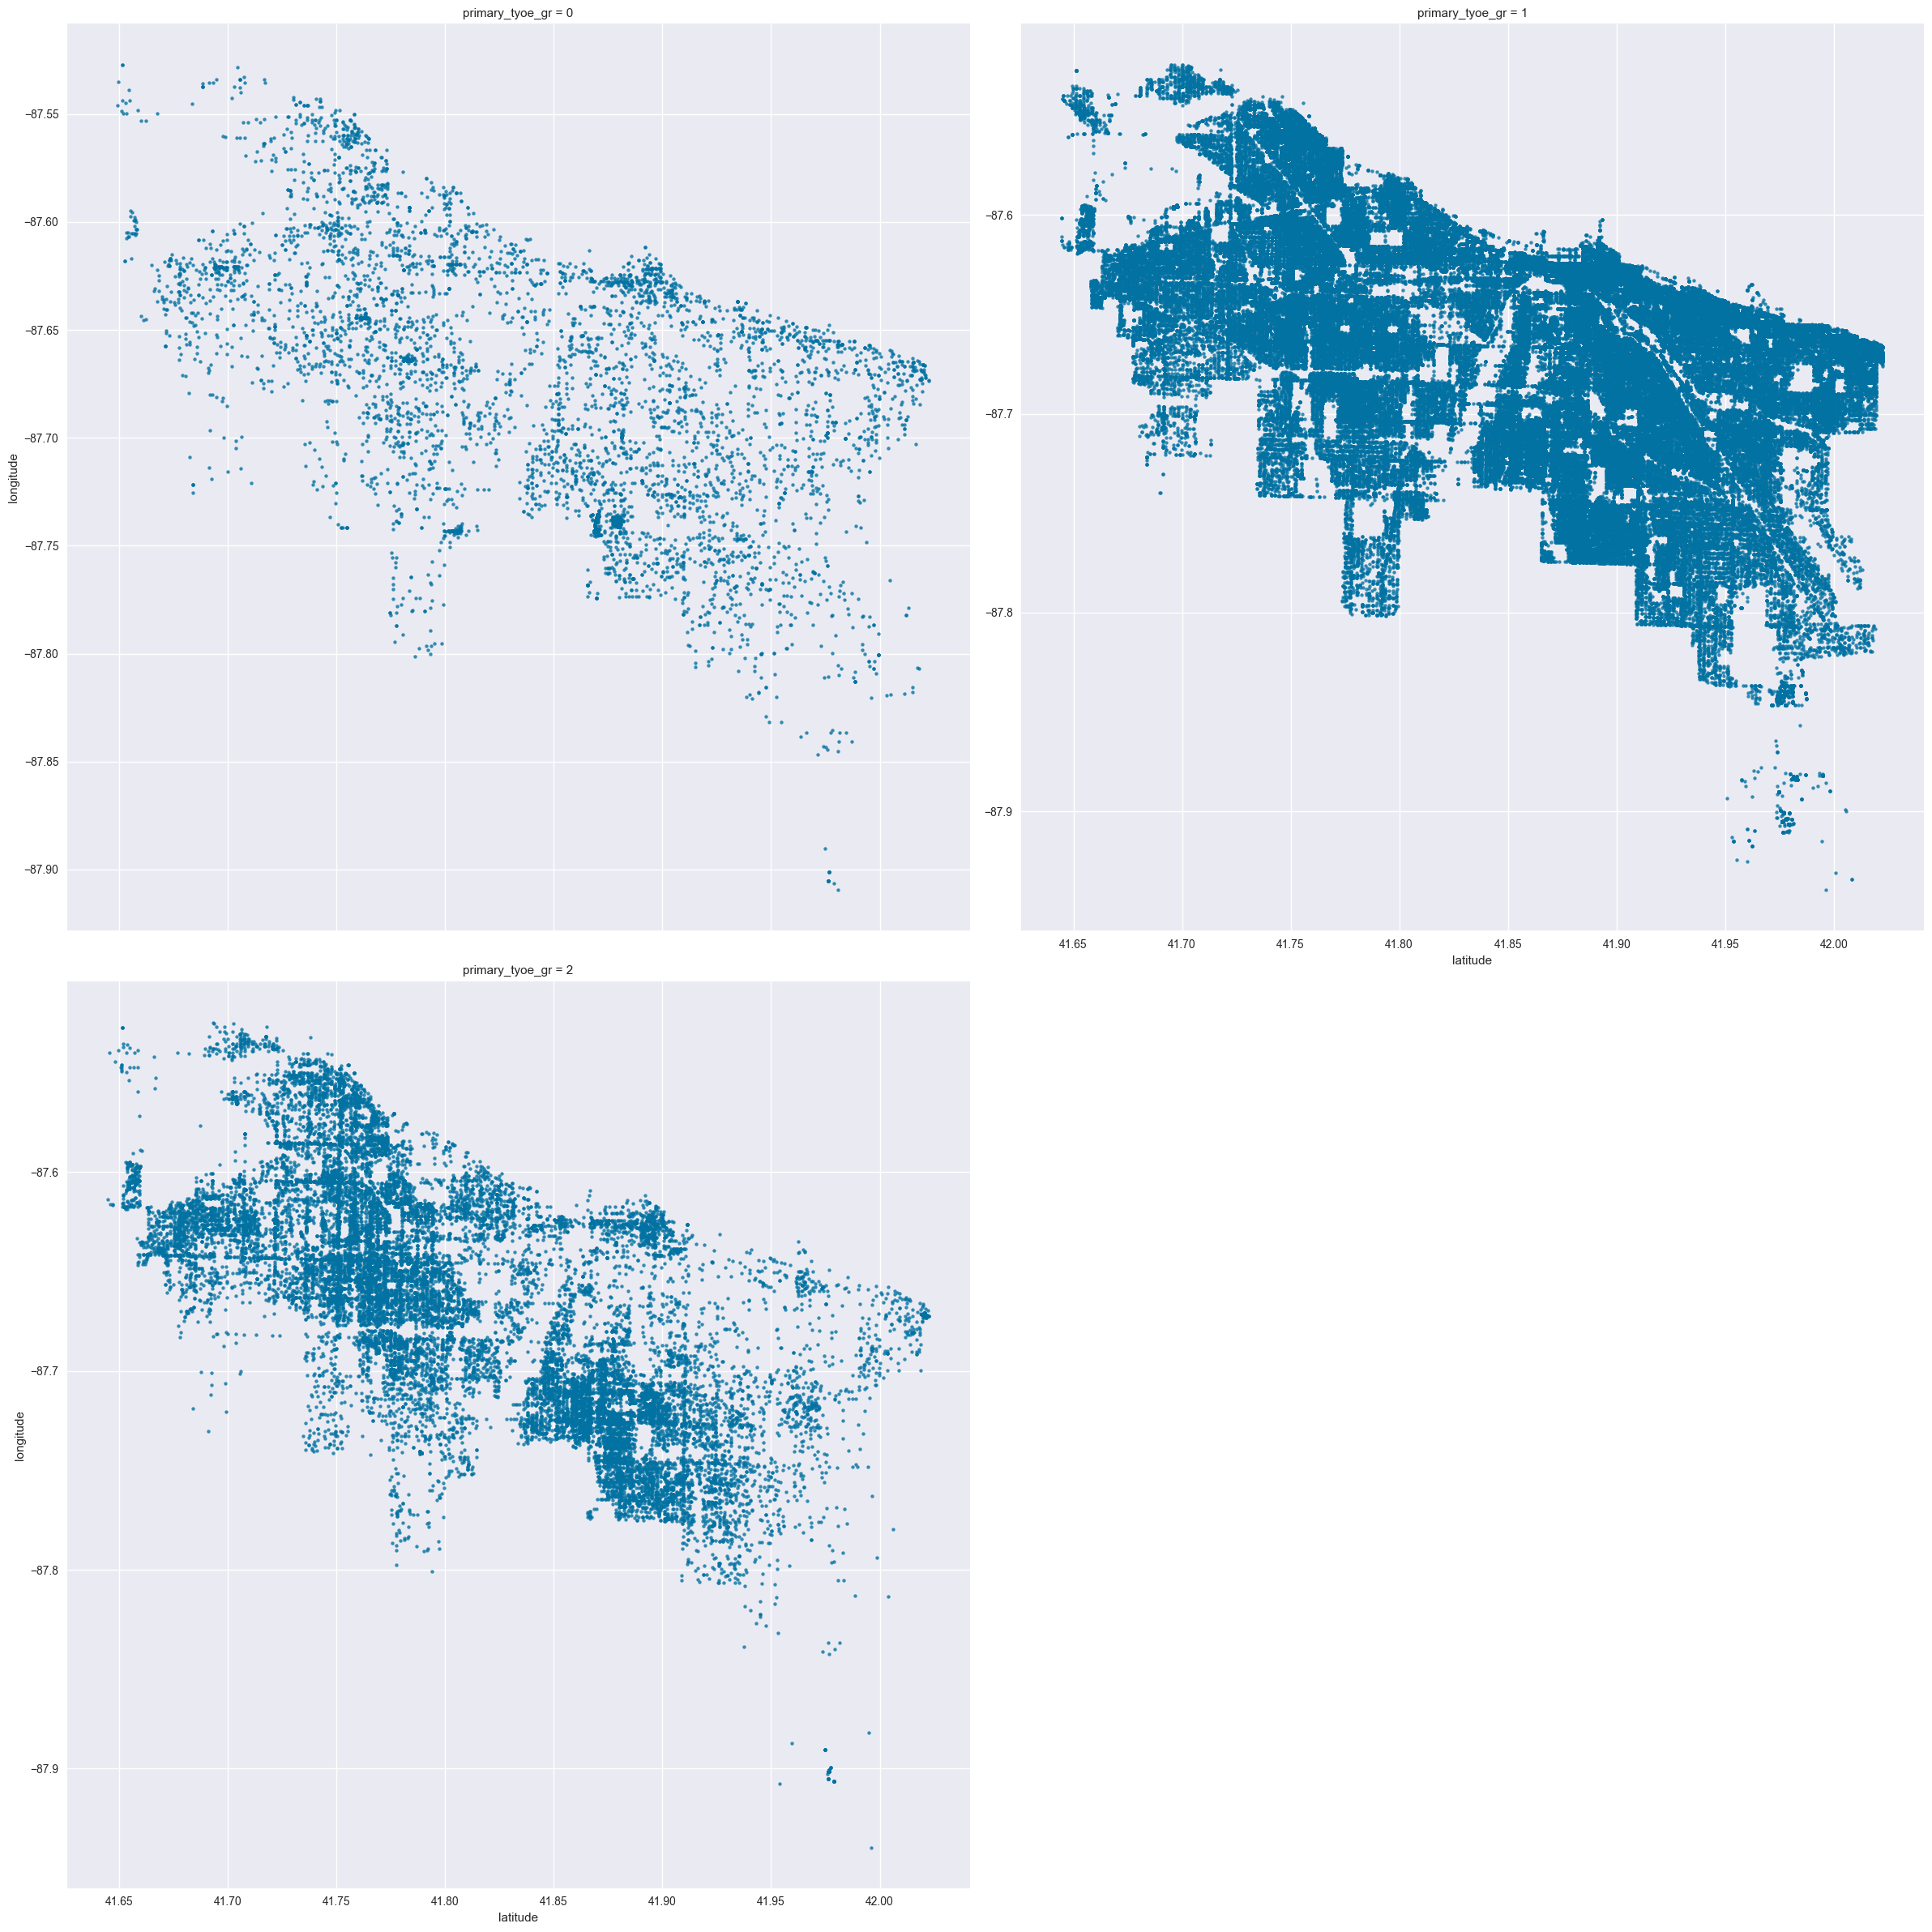

In [65]:
g = sns.lmplot(x='latitude',
               y='longitude',
               col="primary_tyoe_gr",
               data=df,
               col_wrap=2,
                fit_reg=False,
                height=12,
                ci=2,
                sharey=False,
               scatter_kws={"marker": "D",
                            "s": 10})

Observation: As both of the visualizations are almost same which means model is performing good in predicting